In [2]:
import pandas as pd
import joblib
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
import truvari
import glob
from scipy import stats

In [31]:
pop_colours = {
    'AFR': '#FF0000',
    'AMR': '#008000',
    'EAS': '#00FFFF',
    'EAS & Samoan': '#00FFFF',
    'EUR': '#90EE90',
    'MES': '#FFA500',
    'OCN': '#8B0000',
    'SAS': '#1E90FF',
    'KES': '#808080',
    'CMS': '#0000FF',
}

In [3]:
data = []
for i in glob.glob("results/*lite.jl"):
    d = joblib.load(i)
    print(d.columns)
    data.append(d)
data = pd.concat(data)

Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')
Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')
Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')


In [4]:
bins = []
labels = []
for i in range(5, 101, 5):
    bins.append(i/ 100)
    labels.append(f"[{i-5},{i})")
bins.insert(0, 0)
data["AFBin"] = pd.cut(data["AF"], bins, labels=labels)
data["GDAFBin"] = pd.cut(data["GD_AF"], bins, labels=labels)

data["filter"] = data["filter"].apply(lambda x: x[0])
data['is_gnomAD'] = ~data["GD_ID"].isna()
data['is_1000g'] = ~data["1000g_event"].isna()
data['known'] = data['is_gnomAD'] | data['is_1000g']
data['count'] = 1
pass_only = data["filter"] == 'PASS'

In [5]:
filtered = data.loc[~pass_only]
data = data.loc[pass_only]

In [6]:
new_bins = [0, 1000, 5000, 10000, 20000, 50000, 100000, 1e7]
labels = ["[0,1kb)", "[1kb, 5kb)", "[5kb, 10kb)", "[10kb, 20kb)", "[20kb, 50kb)", "[50kb, 100kb)", "100kb+"]
data["big_bins"] = pd.cut(data["svlen"], new_bins, labels=labels)

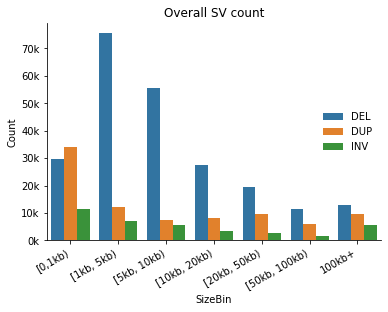

In [7]:
p = sb.countplot(data=data, x="big_bins", hue="svtype", hue_order=["DEL", "DUP", "INV"])
sb.despine()
sb.move_legend(p, "right",
    #bbox_to_anchor=(.5, 1),
    title=None,
    frameon=False,)
p.set(title="Overall SV count", xlabel="SizeBin", ylabel="Count")
hide = plt.yticks(range(0, 80000, 10000), ["{:,d}k".format(x // 1000) for x in range(0, 80000, 10000)])
hide = plt.xticks(rotation=30, ha='right')

In [8]:
data["svlen"].describe().astype(int)

count     355954
mean       48121
std       294380
min           11
25%         2026
50%         5399
75%        15704
max      9984015
Name: svlen, dtype: int64

In [9]:
#pd.options.display.max_rows = None
view = pd.DataFrame(data.groupby(['svtype', 'szbin']).size()[["DEL", "DUP", "INV"]].values.reshape(3, 11),
            index=["DEL", "DUP", "INV"], columns=truvari.SZBINS)
view["Total"] = view.sum(axis=1)
view.loc["Total"] = view.sum(axis=0)
view.style.format("{:,d}")

# NEW VCFs

,"[0,50)","[50,100)","[100,200)","[200,300)","[300,400)","[400,600)","[600,800)","[800,1k)","[1k,2.5k)","[2.5k,5k)",>=5k,Total
DEL,"9,314","6,175","2,737","1,336","2,213","2,832","3,215","1,657","17,368","57,920","127,050","231,817"
DUP,55,"5,573","11,391","4,809","5,222","3,756","1,935","1,279","5,811","6,283","40,797","86,911"
INV,"3,760","3,606","2,648",282,169,316,257,234,"2,134","4,883","18,937","37,226"
Total,"13,129","15,354","16,776","6,427","7,604","6,904","5,407","3,170","25,313","69,086","186,784","355,954"


In [10]:
view_p = ((data.groupby(["svtype", "is_gnomAD", "is_1000g"]).size() / data.groupby(["svtype"]).size()).dropna() * 100).round(1)
view_cnt = data.groupby(["svtype", "is_gnomAD", "is_1000g"]).size()
view = pd.concat([view_cnt, view_p], axis=1)
view.columns = ["Count", "PctOfSVtype"]
view.loc[["DEL", "DUP", "INV"]]

Count  PctOfSVtype
svtype is_gnomAD is_1000g                     
DEL    False     False     100087         43.2
                 True       21219          9.2
       True      False      57300         24.7
                 True       53211         23.0
DUP    False     False      43695         50.3
                 True        7740          8.9
       True      False      24671         28.4
                 True       10805         12.4
INV    False     False      20012         53.8
                 True        6380         17.1
       True      False       8722         23.4
                 True        2112          5.7

In [11]:
view_p = ((data.groupby(["svtype", "known"]).size() / data.groupby(["svtype"]).size()).dropna() * 100).round(1)
view_cnt = data.groupby(["svtype", "known"]).size()
view = pd.concat([view_cnt, view_p], axis=1)
view.columns = ["Count", "PctOfSVtype"]
view.loc[["DEL", "DUP", "INV"]]

Count  PctOfSVtype
svtype known                     
DEL    False  100087         43.2
       True   131730         56.8
DUP    False   43695         50.3
       True    43216         49.7
INV    False   20012         53.8
       True    17214         46.2

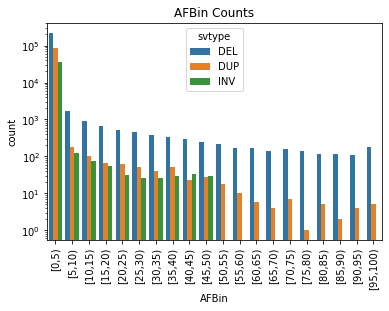

In [21]:
p = sb.countplot(data=data, x="AFBin", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(yscale="log", title="AFBin Counts")
hide = plt.xticks(rotation=90)

In [12]:
data[["UNK", "REF", "HET", "HOM"]] = pd.DataFrame(data['GTCNT'].tolist(), index=data.index)

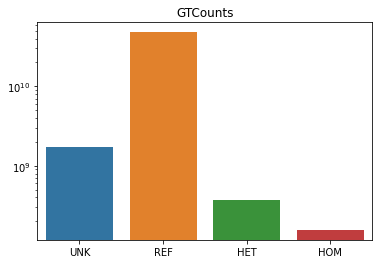

In [13]:
cnts = data[["UNK", "REF", "HET", "HOM"]].sum(axis=0)
p = sb.barplot(x=cnts.index, y=cnts.values)
hide = p.set(yscale="log", title="GTCounts")

In [14]:
singletons = data[["HET", "HOM"]].sum(axis=1) == 1
print("{:,d} singletons {:.2f}%".format(singletons.sum(), singletons.sum() / data.shape[0] * 100))

168,307 singletons 47.28%


In [15]:
data["missing_pct"] = data["UNK"] / data[["UNK", "REF", "HET", "HOM"]].sum(axis=1)

In [16]:
a = data[singletons]["svtype"].value_counts()

In [17]:
b = data["svtype"].value_counts()

In [18]:
view = pd.concat([a, b, a / b], axis=1)
view.columns = ["singletons", "total", "pct"]
view.dropna()

,singletons,total,pct
DEL,101346,231817,0.437181
DUP,45164,86911,0.519658
INV,21797,37226,0.585532


In [19]:
j = view.sum()
print(j["singletons"] / j["total"])

0.47283356838243146


In [20]:
x = (data["AF"] < 0.01).value_counts()
print(x)
print(x[True] / x.sum())

True     339766
False     16188
Name: AF, dtype: int64
0.9545222135444468


In [21]:
hits_gene = data["Gene_name"].isna()
hits_gene.value_counts()

False    183788
True     172166
Name: Gene_name, dtype: int64

In [22]:
len(data)

355954

In [5]:
samp_cnt = joblib.load("../results/PerSampleSVCounts.jl")
cnts = []
print(samp_cnt.keys())
for key in samp_cnt:
    cnts.append(pd.Series(samp_cnt[key], name=key))
samp_cnt = pd.concat(cnts, axis=1)
samp_cnt["sample"] = open("../results/VCFsamples.txt", 'r').readline().strip().split('\t')
samp_cnt["TOT"] = samp_cnt[["DEL", "DUP", "INV"]].sum(axis=1)
samp_cnt = samp_cnt.melt(id_vars=["sample"], value_vars=["DEL", "DUP", "INV", "TOT"])

dict_keys(['DEL', 'DUP', 'INV'])


In [43]:
anc = pd.read_csv("../results/ancestries.txt")
anc['Ancestry'] = anc['Ancestry'].apply(lambda x: "EAS & Samoan" if x == 'EAS' else x)
anc['Ancestry'] = anc['Ancestry'].apply(lambda x: x if x != "OCN" else 'EAS & Samoan')
anc_d = anc.set_index("NWDID")["Ancestry"].to_dict()
samp_cnt["ancestry"] = samp_cnt["sample"].map(anc_d)

EUR             79874
AFR             41756
EAS & Samoan     6869
AMR              4693
SAS              4599
MES               343
Name: Ancestry, dtype: int64


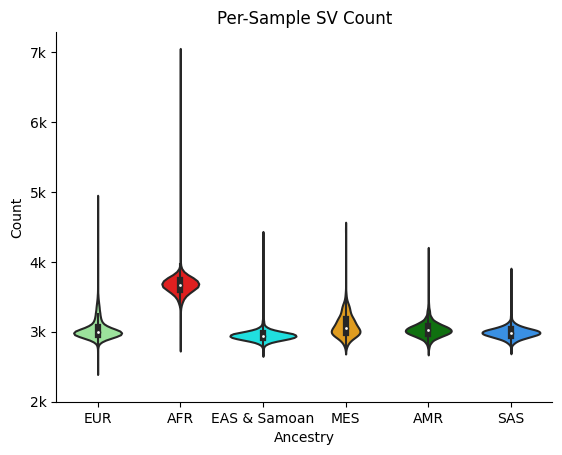

In [44]:
p = sb.violinplot(data=samp_cnt[(samp_cnt["variable"] == "TOT")],
                  x="ancestry", y="value", palette=pop_colours)
sb.despine()
hide = plt.yticks(range(2500, 8000, 1000), ["{:,d}k".format(x // 1000) for x in range(2500, 8000, 1000)])
hide = p.set(title="Per-Sample SV Count", ylabel="Count", xlabel="Ancestry")

# Ancestry Makeup

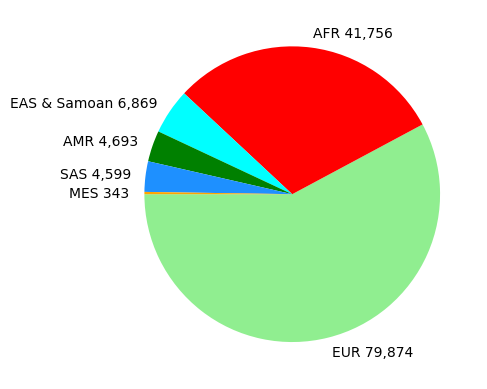

In [45]:
j = anc["Ancestry"].value_counts()
j = pd.DataFrame(j)
j = j[j["Ancestry"] > 10]
j["Pct"] = j["Ancestry"] / j["Ancestry"].sum() * 100
j.reset_index(inplace=True)
labels = ["{} {:,d}".format(x[1]["index"], int(x[1].Ancestry)) for x in j[["index", "Ancestry"]].iterrows()]
j["color"] = j["index"].map(pop_colours)
p = plt.pie(j["Ancestry"], labels = labels, startangle=180, colors=j["color"])

In [38]:
j

,index,Ancestry,Pct,color
0,EUR,79874,57.823981,#90EE90
1,AFR,41756,30.228837,#FF0000
2,EAS & Samoan,6868,4.972020,#00FFFF
3,AMR,4693,3.397450,#008000
4,SAS,4599,3.329400,#1E90FF
5,MES,343,0.248311,#FFA500


In [27]:
j[j["Ancestry"] > 10]["Ancestry"]

0    79874
1    41756
2     6868
3     4693
4     4599
5      343
Name: Ancestry, dtype: int64

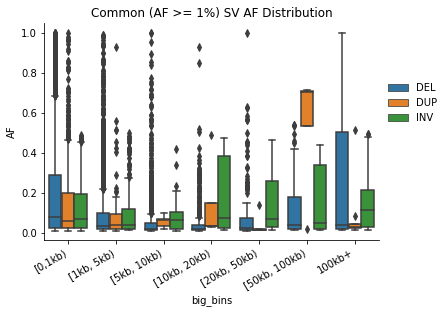

In [28]:
p = sb.boxplot(data=data[data["AF"] >= 0.01], x="big_bins", y="AF", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(title="Common (AF >= 1%) SV AF Distribution")
sb.despine()
sb.move_legend(p, "lower center",
    bbox_to_anchor=(1.1, .5),
    #nrow=3,
    title=None,
    frameon=False,)
hide = plt.xticks(rotation=30, ha="right")

# AF and Size

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_75726/3713057581.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  hide = p.set_xticklabels(ylabels)


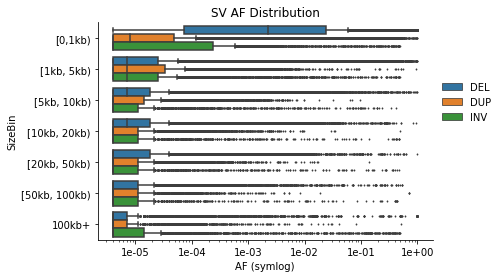

In [29]:
p = sb.boxplot(data=data, y="big_bins", x="AF", 
               hue="svtype", hue_order=["DEL", "DUP", "INV"],
              fliersize=1)
p.set(title="SV AF Distribution", xscale="log", xlabel="AF (symlog)", ylabel="SizeBin")
sb.despine()
sb.move_legend(p, "lower center",
    bbox_to_anchor=(1.1, .5),
    #nrow=3,
    title=None,
    frameon=False,)
ylabels = ['{:.0e}'.format(x) for x in p.get_xticks()]
hide = p.set_xticklabels(ylabels)
#hide = plt.xticks(rotation=30, ha="right")

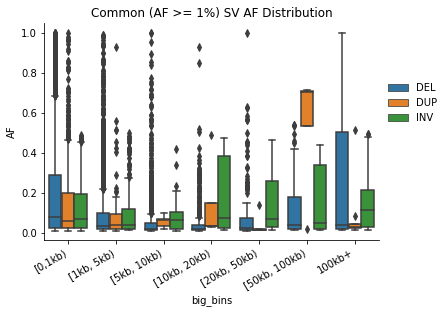

In [30]:
p = sb.boxplot(data=data[data["AF"] >= 0.01], x="big_bins", y="AF", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(title="Common (AF >= 1%) SV AF Distribution")
sb.despine()
sb.move_legend(p, "lower center",
    bbox_to_anchor=(1.1, .5),
    #nrow=3,
    title=None,
    frameon=False,)
hide = plt.xticks(rotation=30, ha="right")

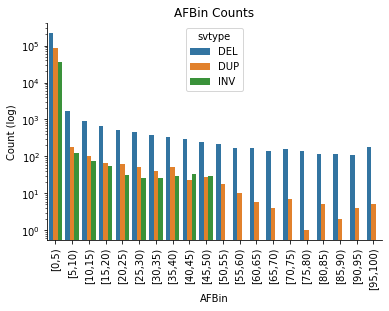

In [31]:
p = sb.countplot(data=data, x="AFBin", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(yscale="log", title="AFBin Counts", ylabel="Count (log)")
sb.despine()
hide = plt.xticks(rotation=90)

# Known Variant Annotations

In [32]:
is_gd = ~data["GD_ID"].isna()
print(is_gd.sum() / len(data))

is_1k = ~data["1000g_event"].isna()
print(is_1k.sum() / len(data))

0.4405653539502295
0.28505649606409816


In [33]:
overlaps = pd.DataFrame(data[is_gd & is_1k]["AF"].reset_index(drop=True))
overlaps["Group"] = "All"
data.loc[is_gd & is_1k, "known"] = "All"

non1kgp = pd.DataFrame(data[is_gd & ~is_1k]["AF"].reset_index(drop=True))
non1kgp["Group"] = "gnomAD"
data.loc[is_gd & ~is_1k, "known"] = "gnomAD"

nongt = pd.DataFrame(data[~is_gd & is_1k]["AF"].reset_index(drop=True))
nongt["Group"] = "1KGP"
data.loc[~is_gd & is_1k, "known"] = "1KGP"
    
topmed = pd.DataFrame(data[~is_gd & ~is_1k]["AF"].reset_index(drop=True))
topmed["Group"] = "TOPMed"
data.loc[~is_gd & ~is_1k, 'known'] = "TOPMed"
#print(len(overlaps), len(non1kgp), len(nongt), len(topmed))

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_75726/2607624267.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  hide = p.set(yscale="log", ylim=(0, 0.15), xlabel="", ylabel="SV Allele Frequency")
/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_75726/2607624267.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  hide = p.set_yticklabels(ylabels)


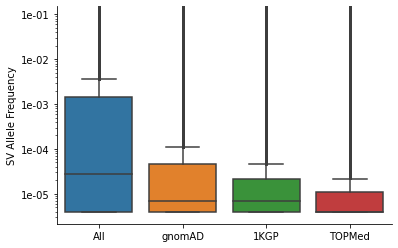

In [34]:
known_afs = pd.concat([overlaps, non1kgp, nongt, topmed])
p = sb.boxplot(data=known_afs, x="Group", y="AF", fliersize=1)
hide = p.set(yscale="log", ylim=(0, 0.15), xlabel="", ylabel="SV Allele Frequency")
sb.despine()
ylabels = ['{:.0e}'.format(x) for x in p.get_yticks()]
hide = p.set_yticklabels(ylabels)

In [35]:
known_sum = known_afs.groupby(["Group"])["AF"].describe()
known_sum["Pct of TOPMed SVs"] = known_sum["count"] / len(data) * 100
known_sum

,count,mean,std,min,25%,50%,75%,max,Pct of TOPMed SVs
Group,,,,,,,,,
1KGP,35339.0,0.006100,0.047575,0.000004,0.000004,0.000007,0.000021,0.999579,9.927968
All,66128.0,0.020029,0.096696,0.000004,0.000004,0.000027,0.001441,0.998170,18.577681
TOPMed,163794.0,0.002819,0.036282,0.000004,0.000004,0.000004,0.000011,0.999996,46.015496
gnomAD,90693.0,0.007951,0.057854,0.000004,0.000004,0.000007,0.000046,0.998901,25.478854


In [36]:
def pct_inc(a, b):
    increase = a - b
    pct_inc = increase / b * 100
    return "{:.1f}%".format(pct_inc)
def mk_row(a, b, k):
    a_mean = k.loc[a]["mean"]
    b_mean = k.loc[b]["mean"]
    mu_rat = a_mean / b_mean
    mu_pct = pct_inc(a_mean, b_mean)

    a_med = k.loc[a]["50%"]
    b_med = k.loc[b]["50%"]
    med_rat = a_med / b_med
    med_pct = pct_inc(a_med, b_med)
    return [a, b, a_mean, b_mean, a_mean / b_mean, pct_inc(a_mean, b_mean), 
            a_med,  b_med, a_med / b_med, pct_inc(a_med, b_med)]

rows = []
for a, b in itertools.combinations(known_sum.index, 2):
        rows.append(mk_row(a, b, known_sum))
        rows.append(mk_row(b, a, known_sum))
known_changes = pd.DataFrame(rows, columns=["Group A", "Group B", 
                                            "A Mean", "B Mean", "A/B Mu Ratio", "Mu A Pct Inc of B",
                                           "A Median", "B Median", "A/B Med Ratio", "Med A Pct Inc of B"])
known_changes

,Group A,Group B,A Mean,B Mean,A/B Mu Ratio,Mu A Pct Inc of B,A Median,B Median,A/B Med Ratio,Med A Pct Inc of B
0,1KGP,All,0.006100,0.020029,0.304560,-69.5%,0.000007,0.000027,0.259259,-74.1%
1,All,1KGP,0.020029,0.006100,3.283422,228.3%,0.000027,0.000007,3.857143,285.7%
2,1KGP,TOPMed,0.006100,0.002819,2.163749,116.4%,0.000007,0.000004,1.750000,75.0%
3,TOPMed,1KGP,0.002819,0.006100,0.462161,-53.8%,0.000004,0.000007,0.571429,-42.9%
4,1KGP,gnomAD,0.006100,0.007951,0.767191,-23.3%,0.000007,0.000007,1.000000,0.0%
5,gnomAD,1KGP,0.007951,0.006100,1.303457,30.3%,0.000007,0.000007,1.000000,0.0%
6,All,TOPMed,0.020029,0.002819,7.104500,610.5%,0.000027,0.000004,6.750000,575.0%
7,TOPMed,All,0.002819,0.020029,0.140756,-85.9%,0.000004,0.000027,0.148148,-85.2%
8,All,gnomAD,0.020029,0.007951,2.519010,151.9%,0.000027,0.000007,3.857143,285.7%
9,gnomAD,All,0.007951,0.020029,0.396981,-60.3%,0.000007,0.000027,0.259259,-74.1%


In [37]:
v = data.groupby(["svtype", "known"]).size().unstack().loc[["DEL", "DUP", "INV"]]
print("pct of SVs with any overlap", 1 - (v["TOPMed"].sum() / len(data)))
print("Pct of SV types with any overlap")
print(v[["1KGP", "All", "gnomAD"]].sum(axis=1)  / data.groupby(['svtype']).size())
print(v.sum() / len(data))
print("gnomad pcts")
print(v["gnomAD"] / data["known"].value_counts()["gnomAD"])
print("1kg pcts")
print(v["1KGP"] / data["known"].value_counts()["1KGP"])
v.sum()

pct of SVs with any overlap 0.5398450361563573
Pct of SV types with any overlap
svtype
DEL    0.568250
INS         NaN
DUP    0.497244
INV    0.462419
NON         NaN
UNK         NaN
dtype: float64
known
1KGP      0.099280
All       0.185777
TOPMed    0.460155
gnomAD    0.254789
dtype: float64
gnomad pcts
svtype
DEL    0.631802
DUP    0.272028
INV    0.096171
Name: gnomAD, dtype: float64
1kg pcts
svtype
DEL    0.600441
DUP    0.219021
INV    0.180537
Name: 1KGP, dtype: float64


known
1KGP       35339
All        66128
TOPMed    163794
gnomAD     90693
dtype: int64

In [40]:
print("gnomad Shared pct", v[["gnomAD", "All"]].sum().sum() / len(data))
print("1kg Shared pct", v[["1KGP", "All"]].sum().sum() / len(data))

gnomad Shared pct 0.4405653539502295
1kg Shared pct 0.28505649606409816


In [43]:
print(v[["gnomAD", "All"]].sum(axis=1))
v[["gnomAD", "All"]].sum(axis=1) / v[["gnomAD", "All"]].sum().sum()

svtype
DEL    110511
DUP     35476
INV     10834
dtype: int64


svtype
DEL    0.704695
DUP    0.226220
INV    0.069085
dtype: float64

In [44]:
print(v[["1KGP", "All"]].sum(axis=1))
v[["1KGP", "All"]].sum(axis=1) / v[["1KGP", "All"]].sum().sum()

svtype
DEL    74430
DUP    18545
INV     8492
dtype: int64


svtype
DEL    0.733539
DUP    0.182769
INV    0.083692
dtype: float64

In [47]:
v["TOPMed"].sum() / len(data)

0.46015496384364274

In [49]:
v["TOPMed"] / data.groupby(["svtype"]).size()

svtype
DEL    0.431750
INS         NaN
DUP    0.502756
INV    0.537581
NON         NaN
UNK         NaN
dtype: float64

In [50]:
v["TOPMed"]

svtype
DEL    100087
DUP     43695
INV     20012
Name: TOPMed, dtype: int64

In [52]:
data.columns

Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name', 'AFBin', 'GDAFBin',
       'is_gnomAD', 'is_1000g', 'known', 'count', 'big_bins', 'UNK', 'REF',
       'HET', 'HOM', 'missing_pct'],
      dtype='object')

In [60]:
x = data[is_gd & (data["AF"] >= 0.01)]["AF"]
y = data[is_gd & (data["AF"] >= 0.01)]["GD_AF"]
print(stats.pearsonr(x, y))

(0.849183237812575, 0.0)


In [63]:
data[singletons]["known"].value_counts() / len(data)

TOPMed    0.261646
gnomAD    0.105736
All       0.055900
1KGP      0.049551
Name: known, dtype: float64

In [64]:
data[singletons]["known"].value_counts() / singletons.sum()

TOPMed    0.553358
gnomAD    0.223621
All       0.118224
1KGP      0.104797
Name: known, dtype: float64

In [66]:
v["TOPMed"].sum()

163794